# Production Capacity Estimation

## Overview

If the cement industry were a country, it would be the third largest emitter in the world - it is the source of about 8% of the world's carbon dioxide (CO2) emissions, according to think tank Chatham House. China currently produces over half of the world’s cement - an estimated 2.2 billion metric tons in 2019. Global cement production is expected to increase to 4.83 billion metric tons in 2030.

![Cement Production](https://ichef.bbci.co.uk/news/976/cpsprodpb/1313C/production/_104804187_biggest_cement_producers_976px_v3-nc.png)

CO2 emissions highly dependent on proportion of clinker used in each tonne of cement - energy efficiency / technology of clinker production are key factors affecting site-specific carbon footprint. 

![Why Clinker is Bad](https://ichef.bbci.co.uk/news/976/cpsprodpb/23B4/production/_104804190_why_clinker_is_bad_976px_v3-nc.png)

Development of a global catalogue of cement factories and their capabilities can dramatically enhance the ability of investors, regulators, governments, and civil society to measure and manage different forms of environmental risk, opportunity, and impact. Production capacity - measured in units of megatons per year - is a key attribute closely linked with site-specific CO2 footprint.

## Objective
This notebook reviews feasibility of training Convolutional Neural Network (CNN) to accurately predict production capacity from VHR optical satellite imagery. Preliminary analysis focussed on training a standard convolutional neural network (CNN) to compute regression between image features extracted by CNN model and floating point estimation of production capacity - expressed in megatons per unit units.

Factors affecting production capacity – (and visible from space):
- availability of raw materials, water supply 
- access to transportation networks
- number and capacity of kilns, grinding mills, silos
- on-site ancillary equipment (preheaters, cooler, exhaust pipes)
- location and local climate

Is it therefore feasible to extract information on various components of production cycle from VHR satellite imagery - kilns, siloes, grinding mills, towers, precoolers – and correlate their layout, size and number to generalised measure of production capacity ? 

## Datasets
High resolution optical satellite imagery coincident with cement plant sites across the world was preprocessed into a collection of 256x256 pixel RGB JPEG files grouped into wet and dry sub-directories. To compute and evaluate model, categorised image chips were divided into training and test subsets according to 80-20 split - https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d. Subsequent cells manage download of this dataset from GCS bucket to local file system using Google Cloud SDK Python API.

Cement plant sites are constructed in wide variety of complex environments – large variation in shape and size of factory sites. Imagery was therefore masked with footprint polygons demarcating perimeter of cement factory site to target pertinent image features during training and reduce effects of redundant background information. Cement factory footprints were extracted as GeoJSON files from Planet OSM landusages table loaded into PostGIS database. Approximately 1500 (~70%) footprint polygons were extracted and validated for preliminary study.

In [1]:
import os

# authentication key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:/Users/Chris.Williams/.gcs/arkham-255409-c59a52d8653f.json'

In [2]:
from google.cloud import storage
from io import BytesIO

# download pretrained model from google cloud
client = storage.Client()
bucket = client.get_bucket('eo-ald-update')

# construct remote path
repo = 'ald'
filenames = [ 'models/vgg16-256-128.zip', 'data/chips.zip' ]

# check files exist
for f in filenames:

    pathname = os.path.join( os.getcwd(), f )
    if not os.path.exists( pathname ):
                
        # make sub-directory if required
        if not os.path.exists ( os.path.dirname( pathname ) ):
            os.makedirs( os.path.dirname( pathname ) )

        # download blob
        remote_url = '{}/cement/capacity/{}'.format( repo, f )

        blob = storage.blob.Blob( remote_url, bucket)
        with open( pathname, 'w+b' ) as z:
            blob.download_to_file( z )


In [3]:
from zipfile import ZipFile

# extract downloaded zip files 
for f in filenames:
    pathname = os.path.join( os.getcwd(), f )
#    with ZipFile( pathname, 'r') as zipObj:
       # extract contents to current directory
#       zipObj.extractall( os.path.dirname( pathname ) )

<BarContainer object of 2 artists>

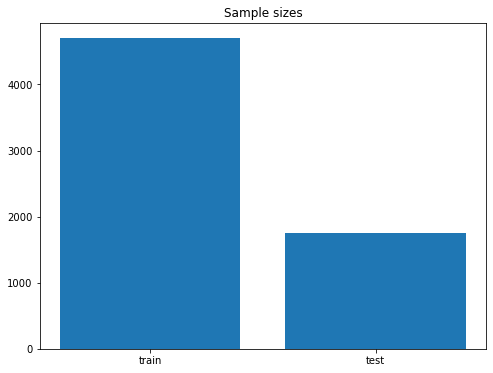

In [4]:
import matplotlib.pyplot as plt

# plot subset sample sizes for wet and dry classes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# get file list length - sample size
count = [None] * 2
for idx, s in enumerate( [ 'train', 'test' ] ):
    path = os.path.join( 'data/chips/', s )
    count[ idx ] = len( os.listdir( path ) )
                
# draw counts as subplot
axes.set_title( 'Sample sizes' )
axes.bar( [ 'train', 'test' ], count )


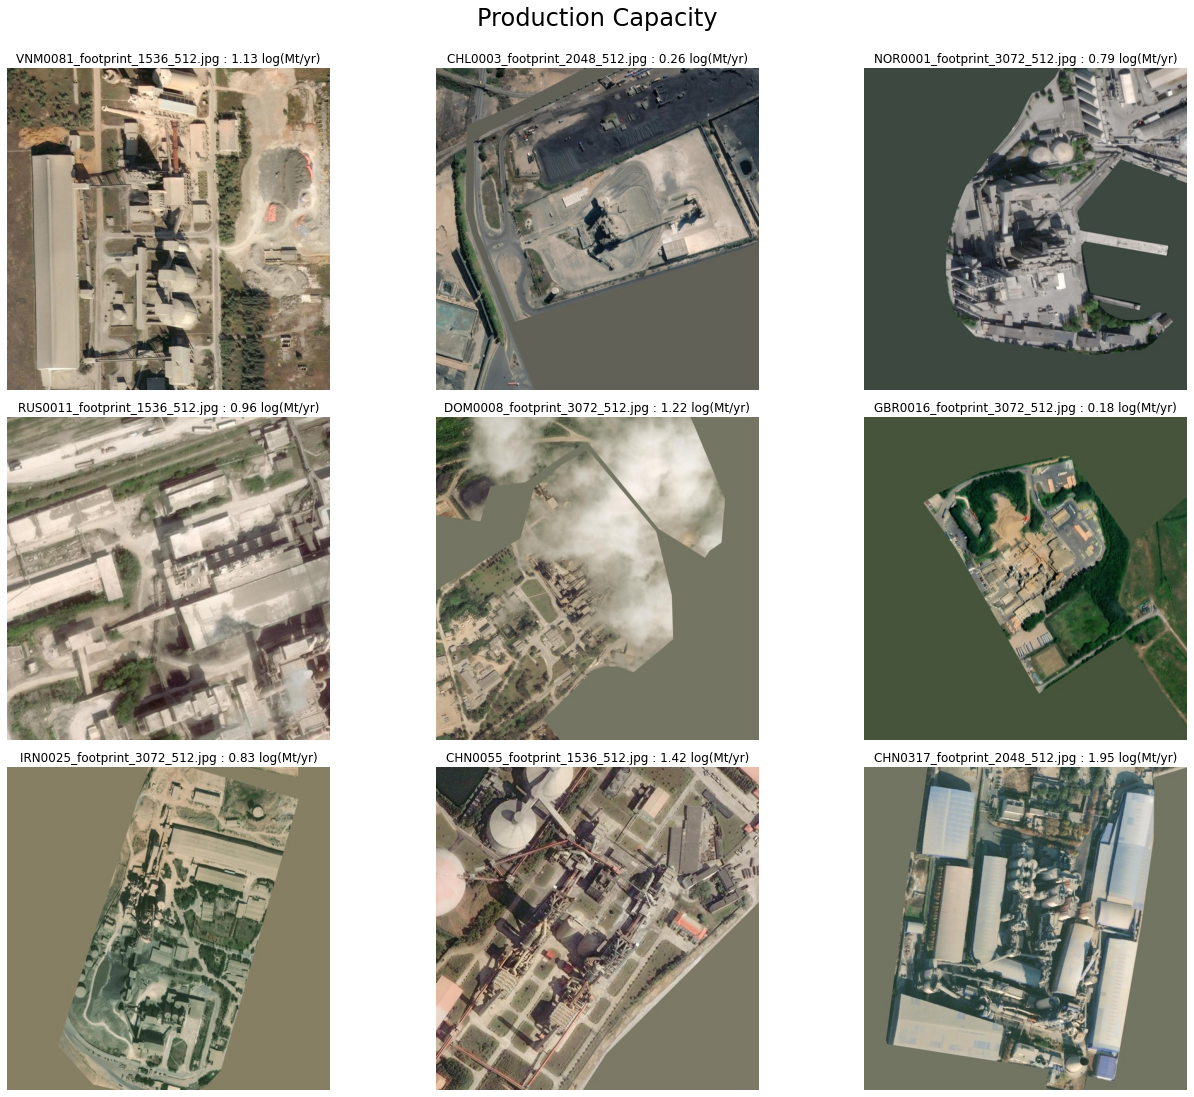

In [5]:
import random
import pandas as pd
from matplotlib.image import imread

df = pd.read_csv( os.path.join( 'data/chips/', 'test.csv' ) )
sample = df.sample(9) 
        
# create figure
fig = plt.figure( figsize=(18, 16) )    
fig.suptitle('Production Capacity', fontsize=24)

# randomly select entries from file list
count = 1
for idx, record in sample.iterrows():

    # define subplot
    ax = plt.subplot( 330 + count )
    ax.set_title( '{} : {:.2f} log(Mt/yr)'.format ( record[ 'image' ], record[ 'target' ] ) )
    plt.axis('off')

    # load and show image
    image = imread( os.path.join( 'data/chips/test', record[ 'image' ] ) )
    plt.imshow(image)

    count += 1

# tight layout with adjustment
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Model Architecture and Training

A pretrained VGG16 CNN model was selected as backbone for this analysis - output from CNN model was flattened and attached to two fully connected layers comprising 256 and 128 units respectively and assigned relu activation functions. The model was trained using an Adam optimiser - learning rate = 1e-6 - combined with mean absolute error loss function.



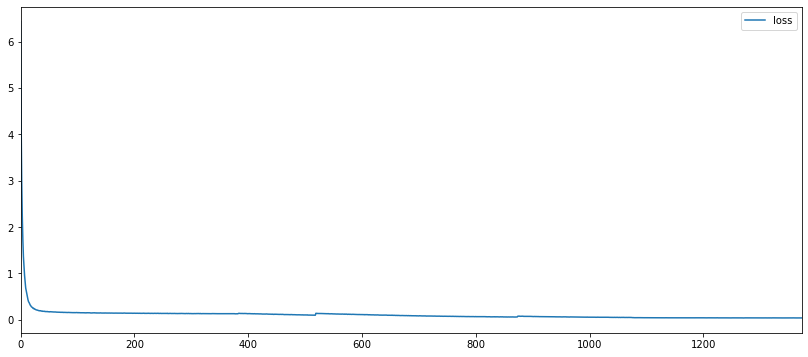

In [6]:
# plot diagnostic information
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# load class-specific diagnostics from csv file
path = 'models/vgg16-256-128/'
df=pd.read_csv( os.path.join( path, 'log.csv') )

# plot diagnostics of model 
df.plot.line( ax=axes, y=['loss'])


## Results

In [7]:
import tensorflow as tf

# initiate tensorflow session - allow access to all onboard CPU / GPU resources
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [8]:
from utility.dl.cnn import loadFromFile

# load pre-trained model from file - downloaded from GCS
model, model_type = loadFromFile( 'models/vgg16-256-128' )

Using TensorFlow backend.



Loaded model from disk: models/vgg16-256-128


In [9]:
import importlib
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator

# select preprocess_input wrapper
module = importlib.import_module( 'keras.applications.{}'.format( model_type ) )
preprocess_input = module.preprocess_input
        
# create test generator
datagen = ImageDataGenerator( preprocessing_function=preprocess_input )
scaler = MinMaxScaler()

In [10]:
import pandas as pd

def getPrediction( datagen, model, df, data_path ):

    # create iterator        
    it = datagen.flow_from_dataframe(   dataframe=df,
                                        directory=data_path,
                                        x_col='image',
                                        y_col='target',
                                        class_mode='raw',
                                        color_mode='rgb',
                                        shuffle=False,
                                        target_size=(256,256),
                                        batch_size=1 )

    # run prediction
    df[ 'yhat' ] = model.predict_generator( it )
    return df

In [11]:
from scipy import stats
import matplotlib.pyplot as plt

def plotRegression( dfs ):

    # create figure
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for idx, df in enumerate( dfs ):

        # compute regression
        m, c, r2, p, err = stats.linregress( df['target'].values, df['yhat'].values )    

        # plot sample data and regression model
        axes[ idx ].plot( df['target'].values, df['yhat'].values, '.' )
        axes[ idx ].plot( [0, 1], [c, m+c], '-', label='y={:.2f}x+{:.2f}\nR2={:.2f}'.format( m, c, r2 ) )
        axes[ idx ].plot( [0, 1], [0, 1], '--', color='g', label='1-to-1' )

        # fix axes and plot 1-2-1 line
        axes[ idx ].set_xlim([0,1])
        axes[ idx ].set_ylim([0,1])

        subset = 'Train' if idx == 0 else 'Test'
        axes[ idx ].set_title( 'Actual vs Estimated Capacity: {}'.format( subset ) )
        axes[ idx ].legend( fontsize=9 )

    plt.show()
    return


Found 3856 validated image filenames.

Found 911 validated image filenames.


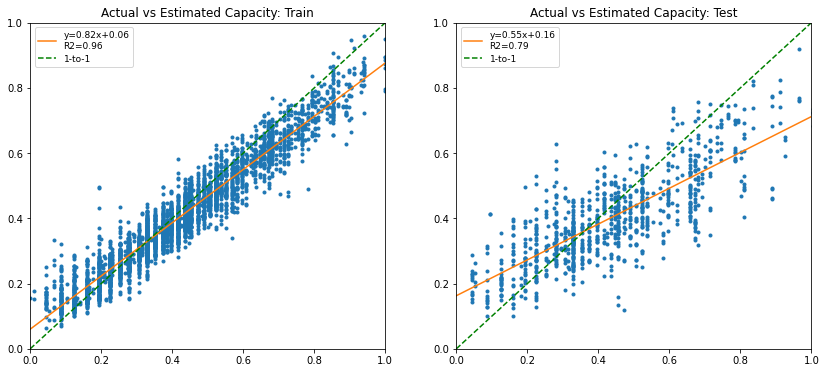

In [12]:
# read dataframe and normalise target
df_train = pd.read_csv( os.path.join( 'data/chips/', 'train.csv' ) )
df_train[ 'target' ] = scaler.fit_transform( df_train[ [ 'target'] ] )

df_train = getPrediction( datagen, model, df_train, os.path.join( 'data/chips/', 'train' ) )

# read dataframe and normalise target
df_test = pd.read_csv( os.path.join( 'data/chips/', 'test.csv' ) )
df_test[ 'target' ] = scaler.transform( df_test[ [ 'target'] ] )

df_test = getPrediction( datagen, model, df_test, os.path.join( 'data/chips/', 'test' ) )

# plot regression
plotRegression( [ df_train, df_test ] )


## Further Analysis

In [13]:
from utility.dp import getUniqueId
import numpy as np

# finally run model against unlabelled images - unknown capacity
path = os.path.join( 'data/chips/', 'unlabelled' )
it = datagen.flow_from_directory( path, 
                                classes=['test'], 
                                color_mode='rgb',
                                shuffle=False,
                                batch_size=1, 
                                target_size=(256,256) )

# evaluate probabilities
y_pred = model.predict_generator( it )

# compile results
records = []
for idx, filename in enumerate ( it.filenames ):

    # assign label and confidence
    records.append (  { 'uid':  getUniqueId( filename ),
                        'capacity' : float( np.exp( y_pred[ idx ] )  ) } )

# convert to dataframe
df = pd.DataFrame.from_dict( records )

# compute mean for each uid - drop duplicates
df[ 'mean' ] = df.groupby(['uid']).capacity.transform( 'mean' )
df.drop_duplicates(subset='uid', keep='first', inplace=True ) 
df = df.drop( columns=[ 'capacity' ] )

for idx, row in df.iterrows():
    print ( row[ 'uid' ], row[ 'mean' ] )


Found 136 images belonging to 1 classes.
AUS0002 1.3269794583320618
AUS0018 1.3906372388203938
AUT0005 1.2782689332962036
BGD0001 1.3767669796943665
BOL0006 1.4321703016757965
BRA0003 1.133134126663208
BRA0026 1.3256968259811401
BRA0035 1.3206732869148254
BRA0036 1.4317745566368103
CAN0011 1.2305892705917358
CHN0193 1.6677945852279663
CZE0002 1.3362635374069214
DEU0001 1.2817554473876953
DEU0004 1.3603215515613556
DEU0010 1.2245471477508545
DEU0011 1.4500985443592072
DEU0012 1.4443204800287883
DEU0024 1.2980201244354248
DEU0029 1.1725948452949524
DEU0048 1.2877745628356934
DOM0007 1.1754271984100342
ESP0045 1.1369425058364868
FRA0022 1.2376250624656677
FRA0040 1.2423460880915325
IDN0002 1.5292215943336487
IND0017 1.2398874163627625
IRN0056 1.3768587112426758
ITA0014 1.3160542249679565
ITA0025 1.2302641868591309
ITA0040 1.1631141901016235
ITA0046 1.2127492427825928
ITA0063 1.2702759504318237
KEN0001 1.1951427459716797
NLD0002 1.46950101852417
PHL0008 1.4774926900863647
ROU0003 1.4339580

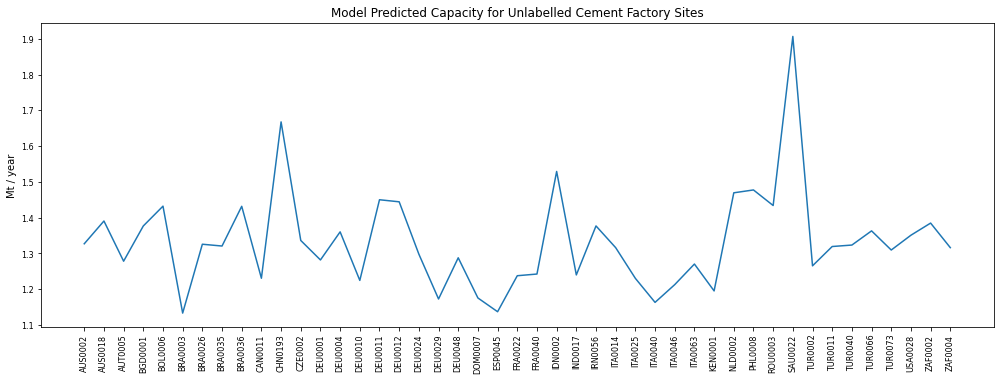

In [14]:
# create figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
axes.set_title( 'Model Predicted Capacity for Unlabelled Cement Factory Sites' )
axes.set_ylabel('Mt / year') 

axes.set_xticks(range(0, len(df) ) )
axes.tick_params(axis='both', which='major', labelsize=8)

axes.set_xticklabels( df[ 'uid' ].tolist(), rotation=90 )
axes.plot( df[ 'mean' ].tolist() )

# show figure
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()
